In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.chdir('02514-Deep-Learning-In-Computer-Vision/')
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
from dataloader_local import DRIVE_data

import matplotlib.pyplot as plt
from IPython.display import clear_output

print("Running on ", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Running on  cpu


In [2]:
torch.cuda.empty_cache()

# Load the data from the first dataset


In [3]:
size = 128
batch_size = 6

dataset = DRIVE_data(train_transform_size=size, test_transform_size=size)
trainset, testset, validationset = dataset.get_datasets()

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)
validation_loader = DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=1)

In [4]:
print('Loaded %d training images' % len(trainset))
print('Loaded %d test images' % len(testset))
print('Loaded %d validation images' % len(validationset))

Loaded 13 training images
Loaded 4 test images
Loaded 3 validation images


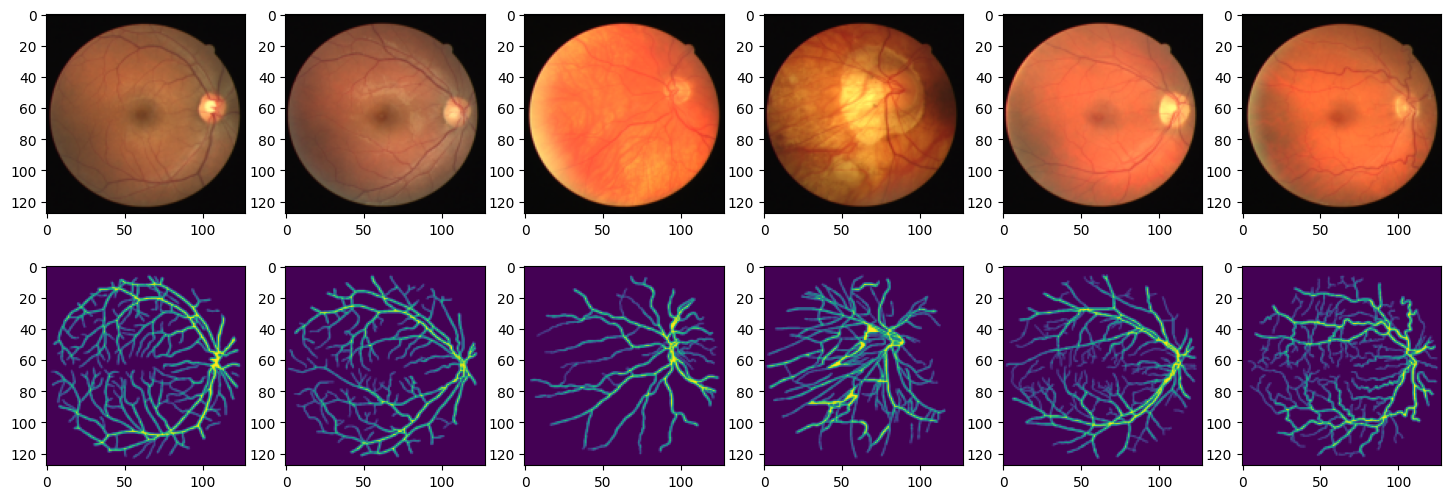

In [5]:
plt.rcParams['figure.figsize'] = [18, 6]

images, labels = next(iter(train_loader))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

    plt.subplot(2, 6, i+7)
    plt.imshow(labels[i].squeeze())
plt.show()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [7]:
images[2].size()

torch.Size([3, 128, 128])

In [8]:
! nvidia-smi

zsh:1: command not found: nvidia-smi


## Set cuda device based on the output 

In [9]:
torch.cuda.device('cuda:0')

## Create a simple CNN

In [10]:
class CNN_Encoder_Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=0)
        self.pool0 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=0)
        self.pool1 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=0)
        self.pool2 = nn.MaxPool2d(2, 2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=0)
        self.pool3 = nn.MaxPool2d(2, 2)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(16)  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        #d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(b)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 16, 3, padding=0)
        self.pool0 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(16, 32, 3, padding=0)
        self.pool1 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(32, 64, 3, padding=0)
        self.pool2 = nn.MaxPool2d(2, 2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=0)
        self.pool3 = nn.MaxPool2d(2, 2)  # 16 -> 8
        self.enc_conv4 = nn.Conv2d(64, 64, 3, padding=0)
        self.pool4 = nn.MaxPool2d(2, 2)  # 8 -> 4

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear')  # 4 -> 8
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 8 -> 16
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 16 -> 32
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 32 -> 64
        self.dec_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear')  # 64 -> 128
        self.dec_conv4 = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))
        e4 = self.pool4(F.relu(self.enc_conv4(e3)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e4))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = F.relu(self.dec_conv3(self.upsample3(d2)))
        d4 = self.dec_conv4(self.upsample4(d3))  # no activation
        return d4


In [12]:
class BasicCNN_one(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.sigmoid(x)
        
        # Resize the output to match the original input size
        x = torch.nn.functional.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)
        
        return x

In [13]:
class BasicCNN_two(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=0)
        self.pool0 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=0)
        self.pool1 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=0)
        self.pool2 = nn.MaxPool2d(2, 2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample1 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e2))

        # decoder
        #d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(b)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

In [14]:
def train(model, opt, loss_fn, epochs, train_loader, test_loader):
    X_test, Y_test = next(iter(test_loader))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            # loss = loss_fn(Y_batch, torch.argmax(Y_pred, dim = 1))  # forward-pass
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(train_loader)
        toc = time()
        print(' - loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = F.sigmoid(model(X_test.to(device))).detach().cpu()
        clear_output(wait=True)
        for k in range(4):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [15]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

In [16]:
def bce_loss(y_real, y_pred, clip = False):
    m = nn.Sigmoid()
    loss = nn.BCELoss()
    return loss(m(y_pred), y_real)
    #return F.binary_cross_entropy_with_logits(y_pred, y_real)
    # return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

# avg_loss = 0
# for X_batch, Y_batch in train_loader:
#     X_batch = X_batch.to(device)
#     Y_batch = Y_batch.to(device)

#     Y_pred = model(X_batch)
#     loss = bce_loss(Y_batch, Y_pred)
    
#     avg_loss += loss / len(train_loader)
# avg_loss

## Training CNN_Encoder_Decoder

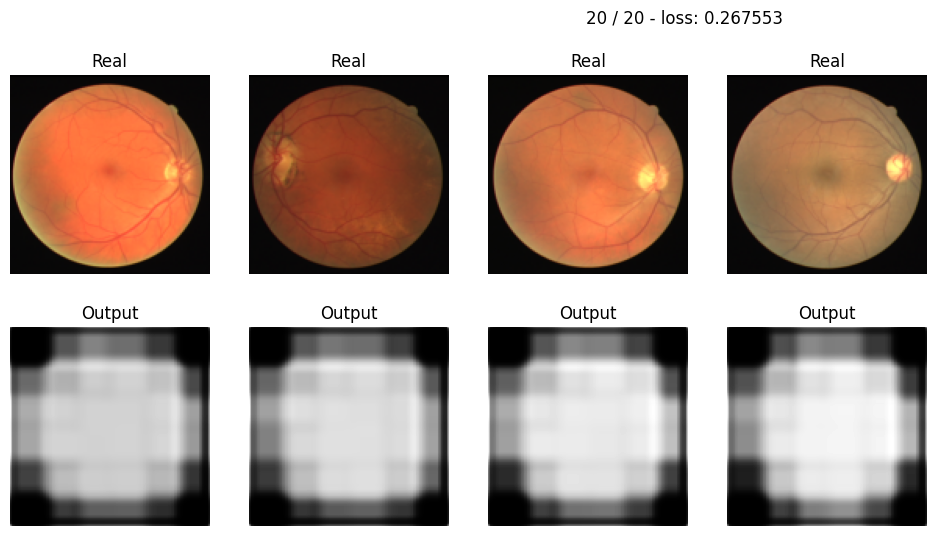

In [17]:
# Leasion | Not leasion data
model = CNN_Encoder_Decoder().to(device)
summary(model, (3, 128, 128))
train(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, test_loader)

## Training SimpleCNN

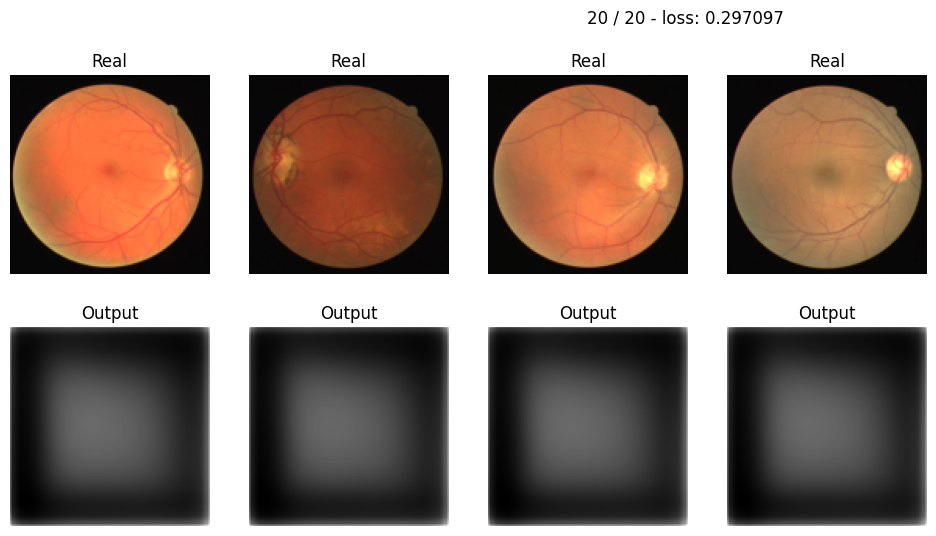

In [18]:
# Leasion | Not leasion data
model = SimpleCNN().to(device)
summary(model, (3, 128, 128))
train(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, test_loader)

## Training BasicCNN

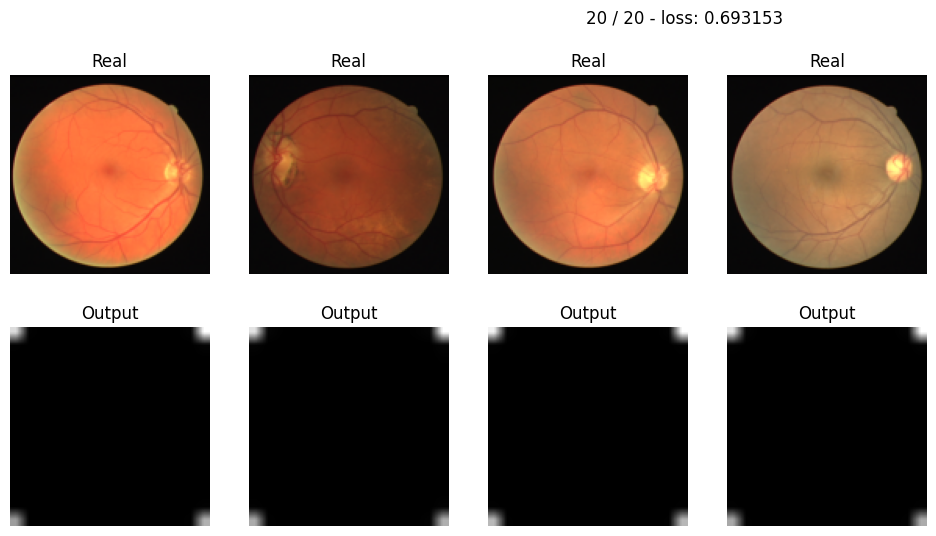

In [19]:
# Leasion | Not leasion data
model = BasicCNN_one().to(device)
summary(model, (3, 128, 128))
train(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, test_loader)

## Train BasicCNN_two

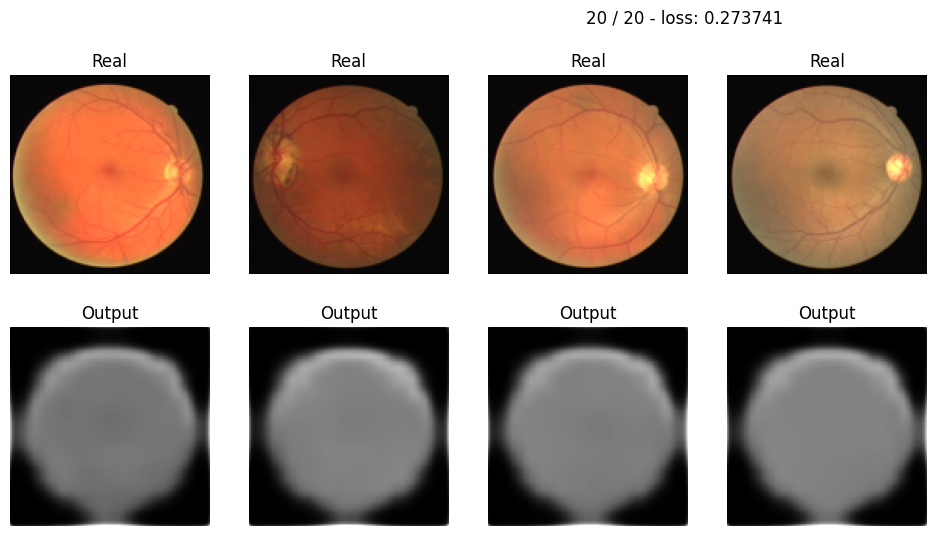

In [20]:
# Leasion | Not leasion data
model = BasicCNN_two().to(device)
summary(model, (3, 128, 128))
train(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, test_loader)

In [49]:
class SimpleCNN3(nn.Module):
    def __init__(self):
        super(SimpleCNN3, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 128 * 128)  # Output layer with size 128x128

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(x.size(0), 1, 128, 128)  # Reshape output to match target size
        return x

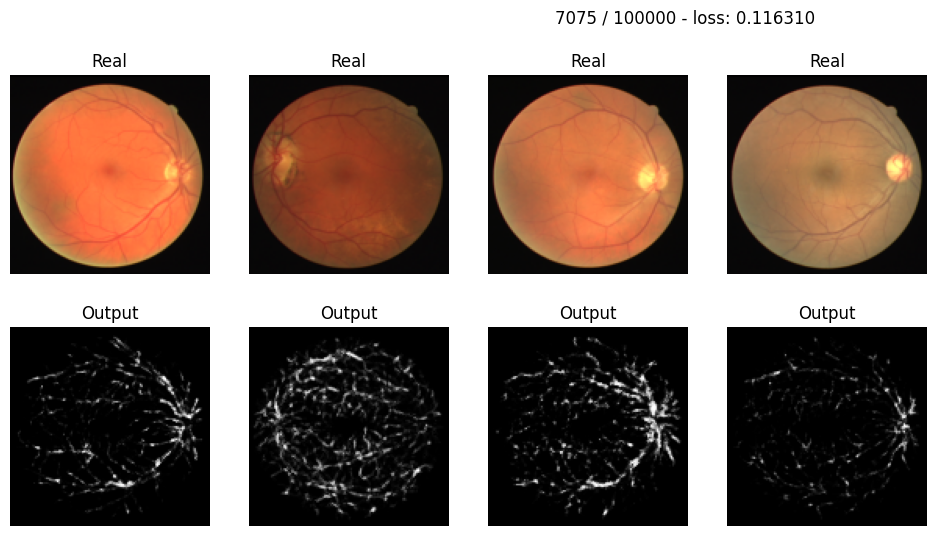

* Epoch 7076/100000
 - loss: 0.128982


In [ ]:
# Leasion | Not leasion data
model = SimpleCNN3().to(device)
summary(model, (3, 128, 128))
train(model, optim.Adam(model.parameters()), bce_loss, 100000, train_loader, test_loader)

# Unet-Architectures

In [22]:
class UNet2Exercise(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        pool_kernel_size = 2
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.Conv2d(64, 64, pool_kernel_size, stride=2)  # 128 -> 64
        # self.pool0 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.Conv2d(64, 64, pool_kernel_size, stride=2)  # 64 -> 32
        # self.pool1 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.Conv2d(64, 64, pool_kernel_size, stride=2)  # 32 -> 16
        # self.pool2 = nn.MaxPool2d(2, 2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        # self.pool3 = nn.MaxPool2d(2, 2)  # 16 -> 8
        self.pool3 = nn.Conv2d(64, 64, pool_kernel_size, stride=2)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        # self.upsample0 = nn.Upsample(16)  # 8 -> 16
        self.upsample0 = nn.ConvTranspose2d(64, 64, 2, stride = 2)
        self.dec_conv0 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride = 2)
        # self.upsample1 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample2 = nn.ConvTranspose2d(64, 64, 2, stride = 2)
        # self.upsample2 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample3 = nn.ConvTranspose2d(64, 64, 2, stride = 2)
        # self.upsample3 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(64*2, 1, 3, padding=1)

    def forward(self, x):
        # obs - we split the pooling and the conv layers to be able to concatenate them later in the skip connection
        # encoder
        e0 = F.relu(self.enc_conv0(x))
        e01 = self.pool0(e0)
        e1 = F.relu(self.enc_conv1(e01))
        e11 = self.pool1(e1)
        e2 = F.relu(self.enc_conv2(e11))
        e21 = self.pool2(e2)
        e3 = F.relu(self.enc_conv3(e21))
        e31 = self.pool3(e3)
        

        # bottleneck
        b = F.relu(self.bottleneck_conv(e31))

        # decoder
        # u0 = self.upsample0(b)
        d0 = F.relu(self.dec_conv0(torch.cat([self.upsample0(b), e3], 1)))
        d1 = F.relu(self.dec_conv1(torch.cat([self.upsample1(d0), e2], 1)))
        d2 = F.relu(self.dec_conv2(torch.cat([self.upsample2(d1), e1], 1)))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0], 1))  # no activation
        return d3

## Training UnetBasic

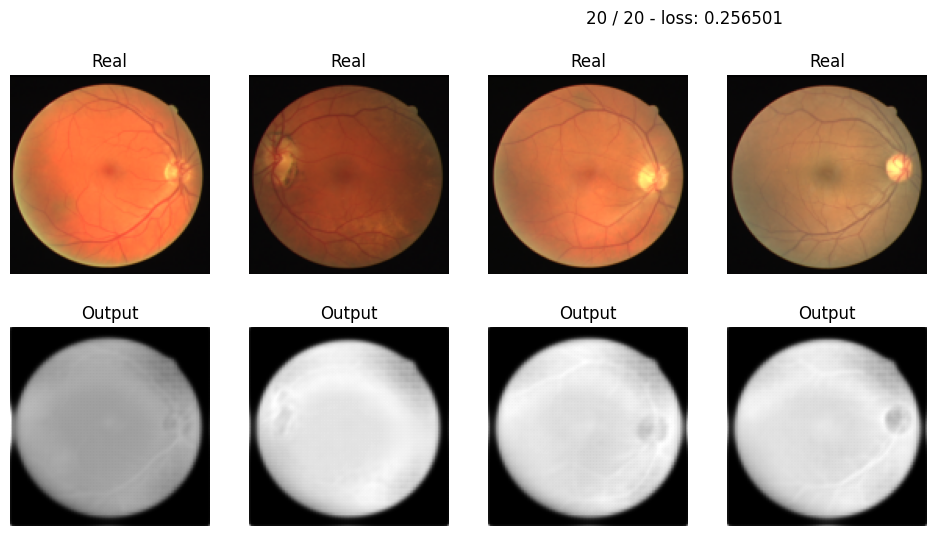

In [23]:
# Leasion | Not leasion data
model = UNet2Exercise().to(device)
summary(model, (3, 128, 128))
train(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, test_loader)

In [27]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Downward part
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.enc_conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_conv3 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.enc_conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.enc_conv5 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.enc_conv6 = nn.Conv2d(256, 512, 3, padding=1)
        self.enc_conv7 = nn.Conv2d(512, 512, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.enc_conv8 = nn.Conv2d(512, 1024, 3, padding=1)
        self.enc_conv9 = nn.Conv2d(1024, 1024, 3, padding=1)

        # Upward part
        self.upsample0 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec_conv0 = nn.Conv2d(1024, 512, 3, padding=1)
        self.dec_conv1 = nn.Conv2d(512, 512, 3, padding=1)
        self.upsample1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec_conv2 = nn.Conv2d(512, 256, 3, padding=1)
        self.dec_conv3 = nn.Conv2d(256, 256, 3, padding=1)
        self.upsample2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec_conv4 = nn.Conv2d(256, 128, 3, padding=1)
        self.dec_conv5 = nn.Conv2d(128, 128, 3, padding=1)
        self.upsample3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec_conv6 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec_conv7 = nn.Conv2d(64, 64, 3, padding=1)

        # Classification
        self.dec_conv8 = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        # Downward part
        x1 = nn.ReLU()(self.enc_conv0(x))
        x1 = nn.ReLU()(self.enc_conv1(x1))
        x2 = self.pool1(x1)
        x2 = nn.ReLU()(self.enc_conv2(x2))
        x2 = nn.ReLU()(self.enc_conv3(x2))
        x3 = self.pool2(x2)
        x3 = nn.ReLU()(self.enc_conv4(x3))
        x3 = nn.ReLU()(self.enc_conv5(x3))
        x4 = self.pool3(x3)
        x4 = nn.ReLU()(self.enc_conv6(x4))
        x4 = nn.ReLU()(self.enc_conv7(x4))
        x5 = self.pool4(x4)
        x5 = nn.ReLU()(self.enc_conv8(x5))
        x5 = nn.ReLU()(self.enc_conv9(x5))

        # Upward part
        x6 = self.upsample0(x5)
        x6 = torch.cat([x4, x6], dim=1)
        x6 = nn.ReLU()(self.dec_conv0(x6))
        x6 = nn.ReLU()(self.dec_conv1(x6))
        x7 = self.upsample1(x6)
        x7 = torch.cat([x3, x7], dim=1)
        x7 = nn.ReLU()(self.dec_conv2(x7))
        x7 = nn.ReLU()(self.dec_conv3(x7))
        x8 = self.upsample2(x7)
        x8 = torch.cat([x2, x8], dim=1)
        x8 = nn.ReLU()(self.dec_conv4(x8))
        x8 = nn.ReLU()(self.dec_conv5(x8))
        x9 = self.upsample3(x8)
        x9 = torch.cat([x1, x9], dim=1)
        x9 = nn.ReLU()(self.dec_conv6(x9))
        x9 = nn.ReLU()(self.dec_conv7(x9))

        # Classification
        outputs = self.dec_conv8(x9)

        return outputs


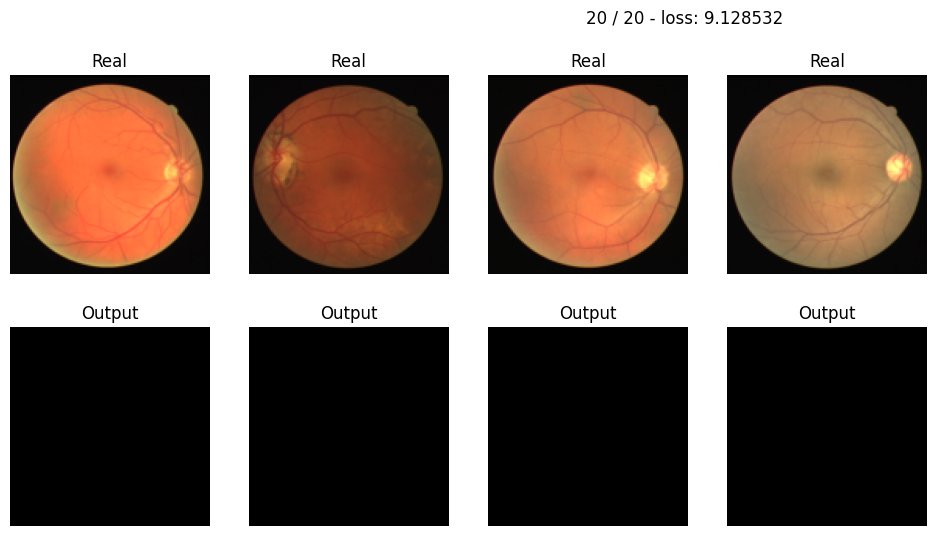

In [28]:
# Leasion | Not leasion data
model = UNet().to(device)
summary(model, (3, 128, 128))
train(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, test_loader)

In [31]:
class UNet3(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample1 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample2 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(128, 1, 3, padding=1)
    
    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        skip0 = torch.cat([self.upsample0(b), F.relu(self.enc_conv3(e2))], 1)
        d0 = F.relu(self.dec_conv0(skip0))
        skip1 = torch.cat([self.upsample1(d0), F.relu(self.enc_conv2(e1))], 1)
        d1 = F.relu(self.dec_conv1(skip1))
        skip2 = torch.cat([self.upsample2(d1), F.relu(self.enc_conv1(e0))], 1)
        d2 = F.relu(self.dec_conv2(skip2))
        skip3 = torch.cat([self.upsample3(d2), F.relu(self.enc_conv0(x))], 1)
        d3 = self.dec_conv3(skip3)  # no activation
        return d3
     


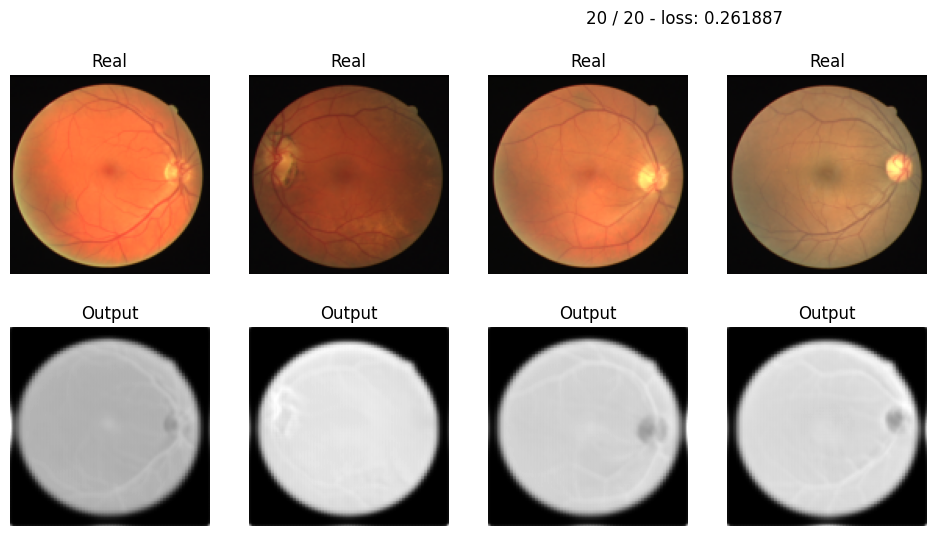

In [32]:
# Leasion | Not leasion data
model = UNet3().to(device)
summary(model, (3, 128, 128))
train(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, test_loader)

## Segnet

In [40]:
class SegNet(nn.Module):
    def __init__(self, num_classes=1):
        super(SegNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.MaxUnpool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Final convolutional layer for segmentation
        self.segmentation = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        sizes = []
        indices = []
        for module in self.encoder:
            if isinstance(module, nn.MaxPool2d):
                sizes.append(x.size())
                x, index = module(x)
                indices.append(index)
            else:
                x = module(x)

        # Decoder
        for module in self.decoder:
            if isinstance(module, nn.MaxUnpool2d):
                index = indices.pop()
                size = sizes.pop()
                x = module(x, index, output_size=size)
            else:
                x = module(x)

        # Segmentation
        x = self.segmentation(x)

        return x

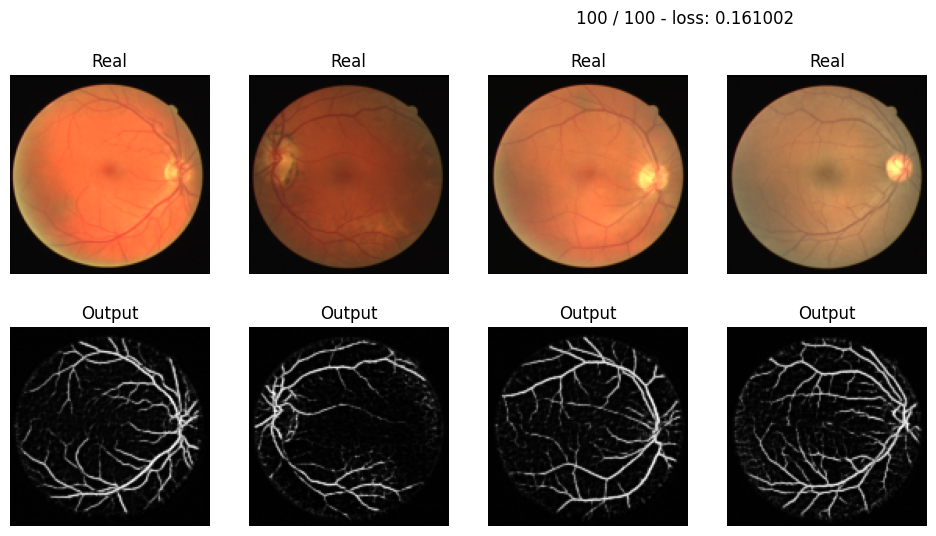

In [41]:
# Leasion | Not leasion data
model = SegNet().to(device)
summary(model, (3, 128, 128))
train(model, optim.Adam(model.parameters()), bce_loss, 100, train_loader, test_loader)